In [55]:
import os 
os.environ['PROJ_LIB'] = "/home/jesseake/skagit-met/.pixi/envs/analysis/share/proj"
import xarray as xr

In [71]:
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holoviews as hv
import datetime as dt
import hvplot.xarray
import hvplot.dask
import rioxarray as rxr
import geopandas as gpd
from shapely import vectorized
hv.extension('matplotlib')#, 'bokeh')

In [57]:
from datetime import datetime as dt
ar_1990 = ('1990-11-03', '1990-11-17')
ar_1995 = ('1995-11-22', '1995-12-06')
ar_2003 = ('2003-10-14', '2003-10-28')
ar_2006 = ('2006-10-31', '2006-11-13')
ar_2011 = ('2011-01-01', '2011-02-01')
ar_2021 = ('2021-11-10', '2021-11-17')
ars = [ar_1990, ar_1995, ar_2003, ar_2006]
dem = xr.open_dataset('../Data/GIS/SkagitRiver_90mDEM.tif')
poly = gpd.read_file('../Data/GIS/SkagitRiver_BasinBoundary.json').geometry
skagit_dem = dem.rio.clip(poly)

# Remmeber WRF and PNNL are hourly
# SNOTEL and WRF alread have hgt/HGT data
def openDataset(dates: tuple[str], product: str, frequency: str = '', resolution: str = '') -> xr.Dataset:
    if product.lower() == 'pnnl':
        grid_path = '/data0/skagit_met/PNNL/historical/SERDP6km.geo_em.d01.nc'
        ds_grid = xr.open_dataset(grid_path).squeeze() # Drop Time=0 scalar dimension
        # Assign Coordinates in Xarray (keep landmask for viz) 
        dsg = ds_grid[['LANDMASK','CLONG','CLAT']]
        # Still not recognized as multidimensional coordinates
        # Rename to x and y To match data files
        dsg = dsg.set_coords(("CLONG", "CLAT")).rename(dict(south_north='y', west_east='x'))
        virtual_pnnl = '/data0/skagit_met/PNNL/historical/PNNL_historical.parquet'
        pnnl = xr.open_dataset(virtual_pnnl, engine='kerchunk', mask_and_scale=False)
        pnnl.assign_coords(dsg.coords)
        # Also bring in land mask
        pnnl.coords['LANDMASK'] = dsg.LANDMASK
        # skagit = gpd.read_file('~/skagit-met/Data/GIS/SkagitBoundary.json')
        mask = vectorized.contains(poly.geometry[0], pnnl.CLONG.values, pnnl.CLAT.values)
        ds = pnnl.where(mask)
        ds = ds.sel(time=slice(dates[0], dates[1]))
        pnnl = None
    elif product.lower() == 'ornl':
        start = dt.fromisoformat(dates[0]).year
        end = dt.fromisoformat(dates[1]).year
        ds = xr.open_zarr(f'/data0/skagit_met/atmospheric_rivers/{start}_{end}_ORNL_data.zarr')
        ds = ds.sel(time=slice(dates[0],dates[1]))
    else:
        ds = xr.open_zarr(f'/data0/skagit_met/atmospheric_rivers/{dates[0]}_{dates[1]}{"_"+frequency if frequency else ""}{"_"+resolution if resolution else ""}_{product}_data.zarr')

    if product in ['wrf_era5', 'pnnl']:
        ds['T2C'] = ds['T2'] - 273.15

    if product == 'SNOTEL':
        if 'AIR TEMP' in ds:
            ds['T2C'] = (ds['AIR TEMP'] - 32) * (5/9)

        if 'AVG AIR TEMP' in ds:
            ds['AVG_T2C'] = (ds['AVG AIR TEMP'] - 32) * (5/9)
        
        ds['elevation_m'] = ds['elevation_ft'] * 0.3048

    if product.lower() == 'wrf_era5':
        ds['PRCP'] = (ds['RAINC']+ ds['RAINNC'])
        try:
            ds = ds.set_coords('HGT')
        except Exception:
            ds = ds.set_coords('hgt')

    if product.lower() == 'ornl':
        ds['tmean'] = (ds.tmax + ds.tmin) / 2

    return ds

## Us CLAT for pnnnl x/y and x,y for index_x, index_y
def embedDEM(ds: xr.Dataset, dem: xr.Dataset, x: str, y: str, index_x: str = None, index_y: str = None, method: str  = 'nearest') -> xr.Dataset:
    dem_resampled = dem.interp(x=ds[x], y=ds[y], method=method)
    avg_elevation = dem_resampled.mean(dim='band')
    ds['elevation'] = ((index_y if index_y else y, index_x if index_x else x), avg_elevation.band_data.values)
    ds = ds.set_coords('elevation')
    return ds

In [58]:
# PNNL - 6 KM
# PRISM - 4 KM
# UCLA wrf_era5 - 9KM 
# ORNL - 4KM
pnnl_1990 = embedDEM(openDataset(ar_1990, 'pnnl'), skagit_dem, 'CLONG', 'CLAT', 'x', 'y')
pnnl_1995 = embedDEM(openDataset(ar_1995, 'pnnl'), skagit_dem, 'CLONG', 'CLAT', 'x', 'y')
pnnl_2003 = embedDEM(openDataset(ar_2003, 'pnnl'), skagit_dem, 'CLONG', 'CLAT', 'x', 'y')
pnnl_2006 = embedDEM(openDataset(ar_2006, 'pnnl'), skagit_dem, 'CLONG', 'CLAT', 'x', 'y')
pnnl_2011 = embedDEM(openDataset(ar_2011, 'pnnl'), skagit_dem, 'CLONG', 'CLAT', 'x', 'y')

ornl_1990 = embedDEM(openDataset(ar_1990, 'ORNL'), skagit_dem, 'lon', 'lat')
ornl_1995 = embedDEM(openDataset(ar_1995, 'ORNL'), skagit_dem, 'lon', 'lat')
ornl_2003 = embedDEM(openDataset(ar_2003, 'ORNL'), skagit_dem, 'lon', 'lat')
ornl_2006 = embedDEM(openDataset(ar_2006, 'ORNL'), skagit_dem, 'lon', 'lat')
ornl_2011 = embedDEM(openDataset(ar_2011, 'ORNL'), skagit_dem, 'lon', 'lat')

prism_1990 = embedDEM(openDataset(ar_1990, 'PRISM'), skagit_dem, 'lon', 'lat')
prism_1995 = embedDEM(openDataset(ar_1995, 'PRISM'), skagit_dem, 'lon', 'lat')
prism_2003 = embedDEM(openDataset(ar_2003, 'PRISM'), skagit_dem, 'lon', 'lat')
prism_2006 = embedDEM(openDataset(ar_2006, 'PRISM'), skagit_dem, 'lon', 'lat')
prism_2011 = embedDEM(openDataset(ar_2011, 'PRISM', 'daily', '4km'), skagit_dem, 'lon', 'lat')

wrf_1990 = openDataset(ar_1990, 'wrf_era5')
wrf_1995 = openDataset(ar_1995, 'wrf_era5')
wrf_2003 = openDataset(ar_2003, 'wrf_era5')
wrf_2006 = openDataset(ar_2006, 'wrf_era5')
wrf_2011 = openDataset(ar_2011, 'wrf_era5')

# snotel_1990 = openDataset(ar_1990, 'SNOTEL', 'daily')
# snotel_1995 = openDataset(ar_1995, 'SNOTEL', 'daily')
# snotel_2003 = openDataset(ar_2003, 'SNOTEL', 'hourly')
# snotel_2006 = openDataset(ar_2006, 'SNOTEL', 'hourly')

/tmp/ipykernel_3379486/135269556.py:30: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask = vectorized.contains(poly.geometry[0], pnnl.CLONG.values, pnnl.CLAT.values)
/tmp/ipykernel_3379486/135269556.py:30: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask = vectorized.contains(poly.geometry[0], pnnl.CLONG.values, pnnl.CLAT.values)
/tmp/ipykernel_3379486/135269556.py:30: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask = vectorized.contains(poly.geometry[0], pnnl.CLONG.values, pnnl.CLAT.values)
/tmp/ipykernel_3379486/135269556.py:30: DeprecationWarning: The 'shapely.vectorize

In [59]:
# (wrf_1990.PRCP.diff(dim='time').sum(dim=['y', 'x'])/1000).cumsum().hvplot.line()
wrf_1990['PRCP'] = wrf_1990.PRCP.diff(dim='time')
wrf_1995['PRCP'] = wrf_1995.PRCP.diff(dim='time')
wrf_2003['PRCP'] = wrf_2003.PRCP.diff(dim='time')
wrf_2006['PRCP'] = wrf_2006.PRCP.diff(dim='time')
wrf_2011['PRCP'] = wrf_2011.PRCP.diff(dim='time')

In [140]:
(wrf_1990.RAINC.sum(dim=['y', 'x']).diff(dim='time').cumsum()/1000).hvplot.line()

:Curve   [time]   (RAINC)

In [60]:
prism_90_prcp = prism_1990.ppt.sum(dim=['lat', 'lon'])
wrf_90_prcp = wrf_1990.PRCP.sum(dim=['y', 'x'])
ornl_90_prcp = ornl_1990.prcp.sum(dim=['lat', 'lon'])
pnnl_90_prcp = pnnl_1990.PREC_ACC_NC.sum(dim=['y', 'x'])

prism_95_prcp = prism_1995.ppt.sum(dim=['lat', 'lon'])
wrf_95_prcp = wrf_1995.PRCP.sum(dim=['y', 'x'])
ornl_95_prcp = ornl_1995.prcp.sum(dim=['lat', 'lon'])
pnnl_95_prcp = pnnl_1995.PREC_ACC_NC.sum(dim=['y', 'x'])

prism_03_prcp = prism_2003.ppt.sum(dim=['lat', 'lon'])
wrf_03_prcp = wrf_2003.PRCP.sum(dim=['y', 'x'])
ornl_03_prcp = ornl_2003.prcp.sum(dim=['lat', 'lon'])
pnnl_03_prcp = pnnl_2003.PREC_ACC_NC.sum(dim=['y', 'x'])

prism_06_prcp = prism_2006.ppt.sum(dim=['lat', 'lon'])
wrf_06_prcp = wrf_2006.PRCP.sum(dim=['y', 'x'])
ornl_06_prcp = ornl_2006.prcp.sum(dim=['lat', 'lon'])
pnnl_06_prcp = pnnl_2006.PREC_ACC_NC.sum(dim=['y', 'x'])

prism_11_prcp = prism_2011.ppt.sum(dim=['lat', 'lon'])
wrf_11_prcp = wrf_2011.PRCP.sum(dim=['y', 'x'])
ornl_11_prcp = ornl_2011.prcp.sum(dim=['lat', 'lon'])
pnnl_11_prcp = pnnl_2011.PREC_ACC_NC.sum(dim=['y', 'x'])


:DynamicMap   []
   :Curve   [time]   (tp)
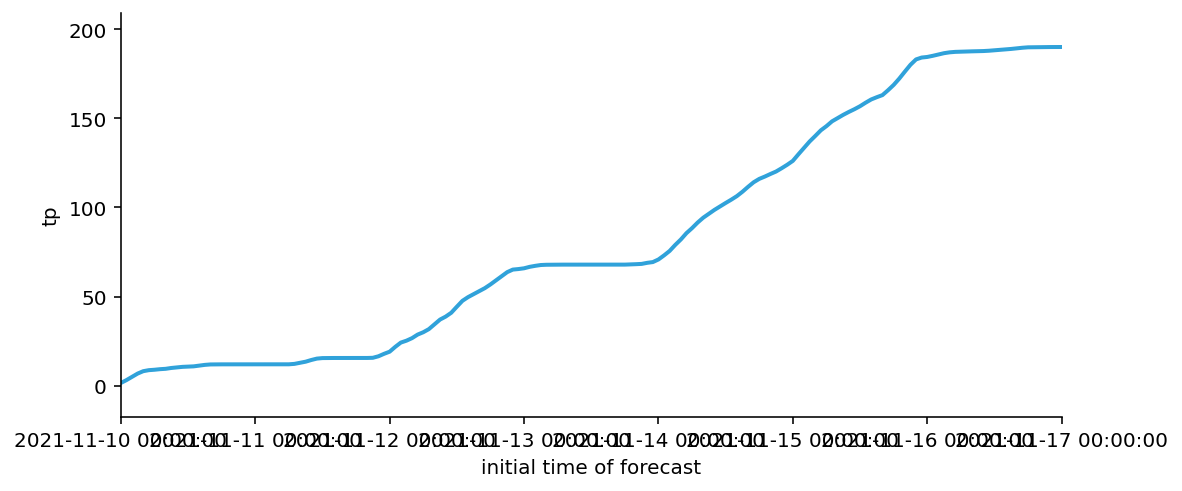

In [61]:
hrrr_2021 = xr.open_dataset('/data0/skagit_met/atmospheric_rivers/2021-11-10_2021-11-17_HRRR_data.zarr')
(hrrr_2021.tp.sum(dim=['x', 'y']).cumsum()/1000).hvplot.line(downsample=True)

In [40]:
# (hrrr_2021.t-273.15).hvplot.quadmesh(x='longitude', y='latitude', rasterize=False)

In [83]:
hv.extension('matplotlib')
hrrr_2021_prcp_daily = hrrr_2021.tp.resample(time='1d').sum().where(hrrr_2021_prcp_daily.tp > 0)
hrrr_gif = hrrr_2021_prcp_daily.hvplot.quadmesh(x='longitude', y='latitude', alpha=0.8, colorbar=True, dynamic=False, clim=(0, hrrr_2021_prcp_daily.max()), use_dask=True).redim.range(z='tp').opts(clabel='Total Precip - Kg/m**2')
# hrrr_gif
hv.save(hrrr_gif, 'hrrr2021', fmt='gif',fps=1)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

NameError: name 'x' is not defined

In [84]:
hrrr_2021_prcp_daily

<xarray.DataArray 'tp' (time: 8, y: 60, x: 54)> Size: 104kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(8, 60, 54), dtype=float32)
Coordinates:
    latitude   (y, x) float64 26kB ...
    longitude  (y, x) float64 26kB ...
  * time       (time) datetime64[ns] 64B 2021-11-10 2021-11-11 ... 2021-11-17
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_DxInMetres:                          3000.0
    GRIB_DyInMetres:                          3000.0
    GRIB_LaDInDegrees:                        38.5
    GRIB_Latin1InDegrees:                     38.5
    GRIB_Latin2InDegrees:                     38.5
    GRIB_LoVInDegrees:                        262.5
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               kg m**-2
    GRIB_uvRelativeToGrid:                    1
    long_name:                                Total Precipitation
    standard_name:                            unknown
    units:                                    kg m**-2

In [32]:
# prism_2021= xr.open_dataset('/data0/skagit_met/atmospheric_rivers/2021-11-03_2021-11-23_PRISM_data.zarr').sel(time=slice(ar_2021[0], ar_2021[1]))
prism_2021_800m = embedDEM(openDataset(ar_2021, 'PRISM', 'daily', '800m'), skagit_dem, 'lon', 'lat').sel(time=slice(ar_2021[0], ar_2021[1]))
# (prism_2021.ppt.sum(dim=['lat', 'lon']).cumsum()).hvplot.line(label='PRISM 4KM') *\
# (prism_2021_800m.ppt.sum(dim=['lat', 'lon'])).hvplot.line(label='PRISM 800m')

In [41]:
gif = (prism_2021_800m.ppt/10).sel(time=slice(ar_2021[0], ar_2021[1])).hvplot.quadmesh(x='lon', y='lat', alpha=0.8, colorbar=True, dynamic=False, clim=(0, (prism_2021_800m.ppt/10).max())).opts(clabel='Total Precip - Kg/m**2')
hv.save(gif, 'prism2021.gif', fmt='gif', fps=3)
# prism_2021_800m.ppt.sel(time=slice('2021-11-11', '2021-11-12')).hvplot.quadmesh()
# prism_2021_800m.ppt.sel(time=slice('2021-11-12', '2021-11-13')).hvplot.quadmesh()
# prism_2021_800m.ppt.sel(time=slice('2021-11-13', '2021-11-14')).hvplot.quadmesh()
# prism_2021_800m.ppt.sel(time=slice('2021-11-14', '2021-11-15')).hvplot.quadmesh()


In [80]:
prism_2021_800m

<xarray.Dataset> Size: 8MB
Dimensions:    (lat: 163, lon: 207, time: 8)
Coordinates:
    crs        int64 8B ...
  * lat        (lat) float64 1kB 49.31 49.3 49.29 49.28 ... 47.98 47.97 47.96
  * lon        (lon) float64 2kB -122.4 -122.4 -122.4 ... -120.7 -120.7 -120.7
  * time       (time) datetime64[ns] 64B 2021-11-10 2021-11-11 ... 2021-11-17
    elevation  (lat, lon) float32 135kB nan nan nan nan nan ... nan nan nan nan
Data variables:
    ppt        (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
    tdmean     (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
    tmax       (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
    tmean      (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
    tmin       (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
    vpdmax     (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
    vpdmin     (time, lat, lon) float32 1MB dask.array<chunksize=(4, 82, 207), meta=np.ndarray>
Attributes:
    Conventions:        CF-1.5
    GDAL:               GDAL 3.4.3, released 2022/04/22
    add_offset:         0.0
    history:            Fri May 23 13:18:30 2025: GDAL CreateCopy( /nfs/panca...
    lat#long_name:      latitude
    lat#standard_name:  latitude
    lat#units:          degrees_north
    lon#long_name:      longitude
    lon#standard_name:  longitude
    lon#units:          degrees_east
    long_name:          GDAL Band Number 1
    scale_factor:       1.0

In [48]:
prcp_90 = ((prism_1990.ppt.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='PRISM 4KM',downsample=True) *\
(wrf_1990.PRCP.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='ERA5 WRF (UCLA) 9KM',downsample=True) *\
(ornl_1990.prcp.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='ORNL 4KM',downsample=True) *\
(pnnl_1990.PREC_ACC_NC.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='PNNL 6KM',downsample=True)).opts(title='1990 Basin Cumulative Precipitation', width=600, height=600).opts(show_grid=True, bgcolor='lightgray', show_legend=True)

prcp_95 = ((prism_1995.ppt.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='PRISM 4KM',downsample=True) *\
(wrf_1995.PRCP.sum(dim=['y', 'x'])/1000).cumsum().hvplot.line(label='ERA5 WRF (UCLA) 9KM',downsample=True) *\
(ornl_1995.prcp.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='ORNL 4KM',downsample=True) *\
(pnnl_1995.PREC_ACC_NC.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='PNNL 6KM',downsample=True)).opts(title='1995 Basin Cumulative Precipitation', width=600, height=600).opts(show_grid=True, bgcolor='lightgray')

prcp_03 = ((prism_2003.ppt.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='PRISM 4KM',downsample=True) *\
(wrf_2003.PRCP.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='ERA5 WRF (UCLA) 9KM',downsample=True) *\
(ornl_2003.prcp.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='ORNL 4KM', downsample=True) *\
(pnnl_2003.PREC_ACC_NC.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='PNNL 6KM', downsample=True)).opts(title='2003 Basin Cumulative Precipitation', width=600, height=600).opts(show_grid=True, bgcolor='lightgray')

prcp_06 = ((prism_2006.ppt.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='PRISM 4KM', downsample=True) *\
(wrf_2006.PRCP.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='ERA5 WRF (UCLA) 9KM', downsample=True) *\
(ornl_2006.prcp.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='ORNL 4KM', downsample=True) *\
(pnnl_2006.PREC_ACC_NC.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='PNNL 6KM', downsample=True)).opts(title='2006 Basin Cumulative Precipitation', width=600, height=600).opts(show_grid=True, bgcolor='lightgray', show_legend=True)

prcp_11 = ((prism_2011.ppt.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='PRISM 4KM', downsample=True) *\
(wrf_2011.PRCP.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='ERA5 WRF (UCLA) 9KM', downsample=True) *\
(ornl_2011.prcp.sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='ORNL 4KM', downsample=True) *\
(pnnl_2011.PREC_ACC_NC.sum(dim=['y', 'x']).cumsum()/1000).hvplot.line(label='PNNL 6KM', downsample=True)).opts(title='2011 Basin Cumulative Precipitation', width=600, height=600).opts(show_grid=True, bgcolor='lightgray', show_legend=True)


plots = (prcp_90 + prcp_95 + prcp_03 + prcp_06 + prcp_11).opts(shared_axes=False).cols(2).opts(legend_position='bottom_left').redim.label(time='Date', ppt='Volume of Precip (m^3)')
hv.save(plots, 'AR_Precip.png')

TypeError: save() missing 1 required positional argument: 'filename'

In [167]:
# pnnl_2011.PREC_ACC_NC.sel(time=slice('2011-01-22', '2011-01-25')).hvplot.quadmesh(x='CLONG', y='CLAT')

In [168]:
# prism_2011.ppt.sel(time=slice('2011-01-22', '2011-01-25')).hvplot.quadmesh(x='lon', y='lat')

In [169]:
# wrf_2011.PRCP.sel(time=slice('2011-01-22', '2011-01-25')).hvplot.quadmesh(x='lon',y='lat')

In [70]:
# (ornl_00_11.prcp.groupby("time.year").sum(dim=['lat', 'lon']).cumsum()/1000).hvplot.line(label='ORNL 4KM - Total Precip', by='time.year', x='time.dayofyear')

In [179]:
# pnnl_2011.T2C.sel(time=slice('2011-01-22', '2011-01-25')).resample(time='1D').mean().hvplot.quadmesh(x='CLONG', y='CLAT')

In [180]:
# prism_2011.tmean.sel(time=slice('2011-01-22', '2011-01-25')).hvplot.quadmesh(x='lon', y='lat')

In [199]:
# pnnl_2006.T2C.sel(time=slice('2006-10-16', '2006-10-18')).resample(time='1D').mean().hvplot.quadmesh(x='CLONG', y='CLAT')

In [214]:
pnnl_2003.PREC_ACC_NC.sel(time=slice('2003-10-16', '2003-10-18')).hvplot.quadmesh(x='CLONG', y='CLAT')

:DynamicMap   [time]
   :QuadMesh   [CLONG,CLAT]   (PREC_ACC_NC)

In [208]:
prism_2003.ppt.sel(time=slice('2003-10-16', '2003-10-18')).hvplot.quadmesh(x='lon', y='lat')

:DynamicMap   [time]
   :QuadMesh   [lon,lat]   (ppt)

In [209]:
wrf_2003.PRCP.sel(time=slice('2003-10-16', '2003-10-18')).hvplot.quadmesh(x='lon',y='lat')

:DynamicMap   [time]
   :QuadMesh   [lon,lat]   (PRCP)

In [210]:
pnnl_2003.T2C.sel(time=slice('2003-10-16', '2003-10-18')).resample(time='1D').mean().hvplot.quadmesh(x='CLONG', y='CLAT')

:DynamicMap   [time]
   :QuadMesh   [CLONG,CLAT]   (T2C)

In [211]:
prism_2003.tmean.sel(time=slice('2003-10-16', '2003-10-18')).hvplot.quadmesh(x='lon', y='lat')

:DynamicMap   [time]
   :QuadMesh   [lon,lat]   (tmean)

In [212]:
wrf_2003.T2C.sel(time=slice('2003-10-16', '2003-10-18')).resample(time='1D').mean().hvplot.quadmesh(x='lon',y='lat')

:DynamicMap   [time]
   :QuadMesh   [lon,lat]   (T2C)

In [213]:
# # Combine precipitation variables into a new DataArray for each event and dataset
# precip_data = xr.concat(
#     [
#         xr.concat(
#             [
#                 (ornl_1990.prcp.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="ORNL"),
#                 (wrf_1990.PRCP.sum(dim=["y", "x"]) / 1000).isel(time=-1).assign_coords(dataset="WRF"),
#                 (prism_1990.ppt.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="PRISM"),
#             ],
#             dim="dataset",
#         ).assign_coords(event="1990"),
#         xr.concat(
#             [
#                 (ornl_1995.prcp.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="ORNL"),
#                 (wrf_1995.PRCP.sum(dim=["y", "x"]) / 1000).isel(time=-1).assign_coords(dataset="WRF"),
#                 (prism_1995.ppt.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="PRISM"),
#             ],
#             dim="dataset",
#         ).assign_coords(event="1995"),
#         xr.concat(
#             [
#                 (ornl_2003.prcp.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="ORNL"),
#                 (wrf_2003.PRCP.sum(dim=["y", "x"]) / 1000).isel(time=-1).assign_coords(dataset="WRF"),
#                 (prism_2003.ppt.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="PRISM"),
#             ],
#             dim="dataset",
#         ).assign_coords(event="2003"),
#         xr.concat(
#             [
#                 (ornl_2006.prcp.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="ORNL"),
#                 (wrf_2006.PRCP.sum(dim=["y", "x"]) / 1000).isel(time=-1).assign_coords(dataset="WRF"),
#                 (prism_2006.ppt.sum(dim=["lat", "lon"]) / 1000).isel(time=-1).assign_coords(dataset="PRISM"),
#             ],
#             dim="dataset",
#         ).assign_coords(event="2006"),
#     ],
#     dim="event",
# )

# # Convert to DataFrame for hvplot compatibility
# precip_df = precip_data.to_dataset(name="Precipitation").reset_index(["event", "dataset"])

# # Plot the spread using hvplot.box
# precip_df.hvplot.box(
#     y="Precipitation", by="event", title="Precipitation Spread by Event", width=800, height=400, color="event", legend=True,  ylabel="Cumulative Precipitation (m)",
# ).opts(
#     xlabel="Event",
   
#     show_grid=True,
#     bgcolor="lightgray",
#     box_color="lightblue",
#     box_alpha=0.5,
#     # xticks=precip_df.event.astype(int).values,
#     # xticks_labels=precip_df.event.astype(str).values,
# )
